In [1]:
import pickle
from pydub import AudioSegment
from pyannote.core import Annotation, Segment
from pyannote.core.notebook import Notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
output = pickle.load(open("../../output/run_output/final_diarization_output_MSDWild.pckl", "rb"))

In [5]:
gt_path = "/vol3/sunil/MSDWild/rttms/02187.rttm"

In [6]:
gt = convert_rttm_to_diarization(gt_path, 0)

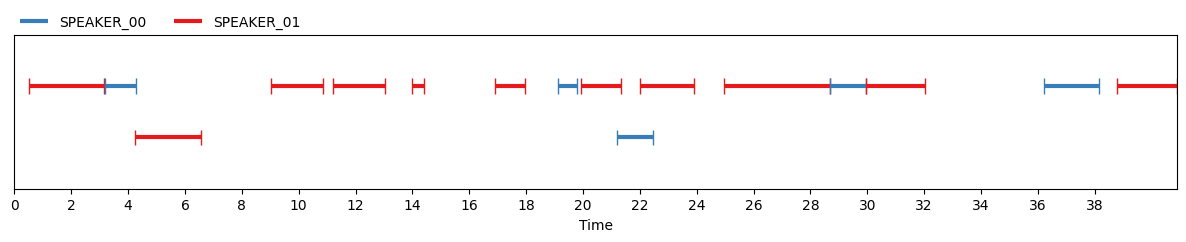

In [7]:
create_annotation_plot(output["02187"]["video_simple"],"02187", get_audio_duration("02187"))

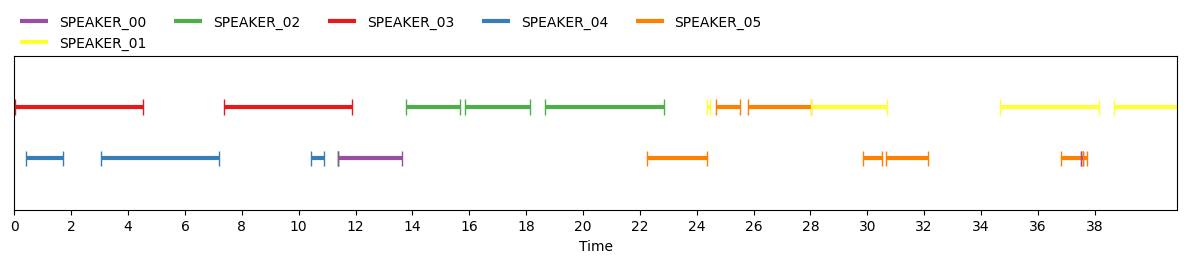

In [8]:
create_annotation_plot(output["02187"]["audio_12"],"02187", get_audio_duration("02187"))

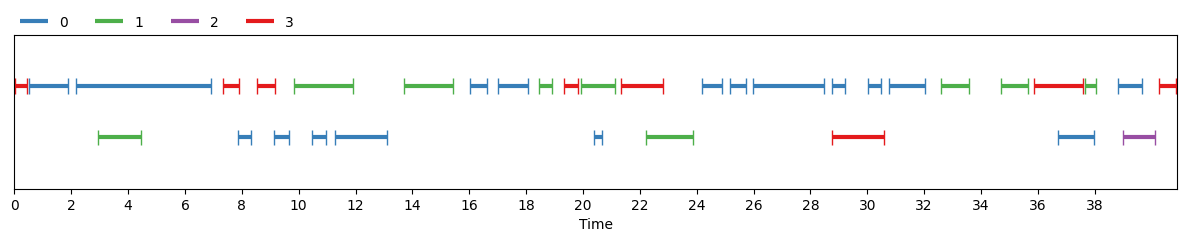

In [9]:
create_annotation_plot(gt ,"02187", get_audio_duration("02187"))

In [2]:
def get_audio_duration(filename):
    audioFilePath = f"../../output/video_temp/{filename}/pywav/audio.wav"
    return len(AudioSegment.from_file(audioFilePath)) / 1000

In [3]:
def create_annotation_plot(
    diarization_output,
    video_name,
    video_duration,
    save_path=None,
    plot_name="diarization",
):
    custom_diarization = Annotation()

    for speaker_key in diarization_output.keys():
        for timeline in diarization_output[speaker_key]:
            custom_diarization[Segment(timeline[0], timeline[1])] = speaker_key

    # Create a figure
    fig, ax = plt.subplots(figsize=(15, 2))

    # Plot the custom diarization result
    nb = Notebook()
    nb.plot_annotation(custom_diarization, ax, legend=True)

    # Customize the plot
    ax.set_xlabel("Time")
    ax.set_yticks([])  # To hide the y-axis
    ax.set_xlim(0, video_duration)
    ax.set_xticks(np.arange(0, int(video_duration), int(video_duration/20)))

    # Save the figure
    if save_path is not None:
        saveFileName = os.path.join(save_path, f"{video_name}_{plot_name}.png")
        fig.savefig(saveFileName, bbox_inches="tight")
        # Close the figure
        ax.clear()
        plt.close(fig)
    else:
        fig.show()

def convert_rttm_to_diarization(rttm_file, offset):

    # Read RTTM file into pandas DataFrame
    rttm_df = pd.read_csv(
        rttm_file,
        sep=" ",
        header=None,
        names=["temp", "file_name", "channel", "start", "duration", "NA_1", "NA_2", "speaker_label", "NA_3", "NA_4"],
    )

    rttm_df.sort_values(by="start", inplace=True)

    diarize_dict = {}

    # Iterate over RTTM rows and add segments to Pyannote annotation
    for _, row in rttm_df.iterrows():
        start_time = round(row["start"] - offset, 2)
        end_time = round(start_time + row["duration"], 2)
        label = row["speaker_label"]
        if label not in diarize_dict.keys():
            diarize_dict[label] = [(start_time, end_time)]
        else:
            diarize_dict[label].append((start_time, end_time))

    return diarize_dict